In [64]:
import argparse
import logging
import sys

import scipy.stats
import scipy
import torch
import seaborn as sns
from model_robustness.model_test.networks import MLP
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from advertorch.attacks import GradientSignAttack, PGDAttack
from pathlib import Path
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [65]:
def epoch(mode, config, net, dataloader, optimizer, criterion):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    if mode == "train":
        net.train()
    else:
        net.eval()
    for i, data in enumerate(dataloader):
        imgs, labels = data

        n_b = labels.shape[0]

        outputs = net(imgs)
        loss = criterion(outputs, labels)

        acc = np.sum(np.equal(np.argmax(outputs.data.numpy(), axis=-1), labels.data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg

In [70]:
# set module parameters
config = {}
config["model::type"] = "MLP"
config["optim::optimizer"] = "adam"
config["optim::lr"] = 0.0003
config["optim::wd"] = 0.000
config["seed"] = 42
config["training::batchsize"] = 16
config["training::epochs_train"] = 10
config["cuda"] = True if torch.cuda.is_available() else False

ROOT = Path("")
data_path = ROOT.joinpath("../model_robustness/data/MNIST/dataset.pt")
param_path = ROOT.joinpath("data/")

In [71]:
dataset = torch.load(data_path)

In [72]:
trainset = dataset["trainset"]
testset = dataset["testset"]
valset = dataset["valset"]

trainloader = DataLoader(
    dataset=trainset,
    batch_size=config["training::batchsize"],
    shuffle=True,
)
testloader = DataLoader(
    dataset=testset,
    batch_size=config["training::batchsize"],
    shuffle=False
)
if valset is not None:
    valloader = DataLoader(
        dataset=valset,
        batch_size=config["training::batchsize"],
        shuffle=False
    )
# init model
net = MLP()

In [79]:
# Creating data + dataloader with perturbations
aux_testloader = DataLoader(dataset=testset, batch_size=len(testset), shuffle=False)
for cln_data, true_labels in aux_testloader:
    pass
adversary = GradientSignAttack(net)
adv_untargeted = adversary.perturb(cln_data, true_labels)
perturbed_data = torch.utils.data.TensorDataset(adv_untargeted, true_labels)

perturbed_testloader = DataLoader(
    dataset=perturbed_data,
    batch_size=config["training::batchsize"],
    shuffle=False
)

In [80]:
optimizer = optim.Adam(net.parameters(), lr=config["optim::lr"], weight_decay=config["optim::wd"])
criterion = nn.CrossEntropyLoss()

In [81]:
perturbed = True
for e in range(config["training::epochs_train"]):
    train_loss, train_acc = epoch("train", config, net, trainloader, optimizer, criterion)
    print(f"[{e +1}] train loss: {train_loss:.3f}, train accuracy: {train_acc:.3f}")

    print("Testing with normal data")
    test_loss, test_acc = epoch("test", config, net, testloader, optimizer, criterion)
    print(f"[{e + 1}] test loss: {test_loss:.3f}, test accuracy: {test_acc:.3f}")

    print("Testing with perturbed data")
    test_loss, test_acc = epoch("test", config, net, perturbed_testloader, optimizer, criterion)
    print(f"[{e + 1}] test loss: {test_loss:.3f}, test accuracy: {test_acc:.3f}")

print("Finished training")

torch.save(net.state_dict(), os.path.join(param_path, "perturbed_model_checkpoint.pt"))

[1] train loss: 0.010, train accuracy: 0.996
Testing with normal data
[1] test loss: 0.134, test accuracy: 0.974
Testing with perturbed data
[1] test loss: 0.349, test accuracy: 0.881
[2] train loss: 0.011, train accuracy: 0.996
Testing with normal data
[2] test loss: 0.118, test accuracy: 0.976
Testing with perturbed data
[2] test loss: 0.302, test accuracy: 0.904
[3] train loss: 0.008, train accuracy: 0.997
Testing with normal data
[3] test loss: 0.121, test accuracy: 0.977
Testing with perturbed data
[3] test loss: 0.339, test accuracy: 0.890
[4] train loss: 0.010, train accuracy: 0.996
Testing with normal data
[4] test loss: 0.114, test accuracy: 0.976
Testing with perturbed data
[4] test loss: 0.332, test accuracy: 0.892
[5] train loss: 0.009, train accuracy: 0.997
Testing with normal data
[5] test loss: 0.110, test accuracy: 0.977
Testing with perturbed data
[5] test loss: 0.292, test accuracy: 0.902
[6] train loss: 0.008, train accuracy: 0.997
Testing with normal data
[6] test l

In [29]:
normal_net = torch.load(os.path.join(param_path, "model_checkpoint.pt"))
perturbed_net = torch.load(os.path.join(param_path, "perturbed_model_checkpoint.pt"))

In [32]:
normal_net.keys()

odict_keys(['fc_1.weight', 'fc_1.bias', 'fc_2.weight', 'fc_2.bias', 'fc_3.weight', 'fc_3.bias'])

In [35]:
normal_net["fc_1.weight"].size()

torch.Size([64, 784])

In [37]:
perturbed_net["fc_1.weight"]

tensor([[-0.0295, -0.0307,  0.0020,  ...,  0.0012, -0.0241,  0.0095],
        [ 0.0204,  0.0210, -0.0379,  ...,  0.0079, -0.0415,  0.0016],
        [-0.0278, -0.0309,  0.0084,  ..., -0.0113, -0.0024, -0.0048],
        ...,
        [-0.0110, -0.0423, -0.0059,  ..., -0.0407, -0.0176, -0.0120],
        [ 0.0371,  0.0295, -0.0153,  ..., -0.0110,  0.0263,  0.0342],
        [-0.0195,  0.0431,  0.0012,  ..., -0.0230,  0.0034, -0.0193]])

Kolmogorov-Smirnov test for goodness of fit (tests whether the underlying distributions of two samples are the same)

In [43]:
ks_test = scipy.stats.ks_2samp(normal_net["fc_1.weight"].flatten(), perturbed_net["fc_1.weight"].flatten(), alternative="two_sided", mode="auto")

In [50]:
ks_test[1]

6.116887364941686e-12

In [51]:
keys = normal_net.keys()

for k in keys:
    aux = scipy.stats.ks_2samp(normal_net[k].flatten(), perturbed_net[k].flatten(), alternative="two-sided", mode="auto")
    print(aux[1])

6.116887364941686e-12
0.842628651159718
0.22310681598300958
0.5256507222485184
0.22256675987036037
0.7869297884777761


## Exploration of the two distributions

From the analysis above, it seems like the weights from the first layer are from two different distributions, so we will mainly focus on those weights.

In [54]:
df = pd.DataFrame(columns=["normal", "perturbed"])
df["normal"] = normal_net["fc_1.weight"].flatten()
df["perturbed"] = perturbed_net["fc_1.weight"].flatten()

In [55]:
df.head()

,normal,perturbed
0,-0.009242,-0.029499
1,-0.029652,-0.030681
2,0.012008,0.001969
3,-0.038208,-0.021828
4,0.021856,-0.018276


### Boxplot

<Axes: >

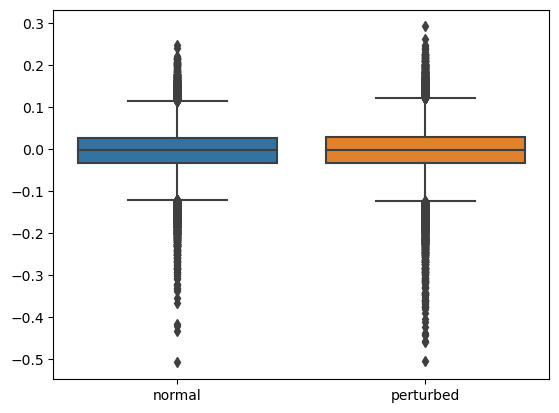

In [56]:
sns.boxplot(df)

### Histogram

<Axes: ylabel='Density'>

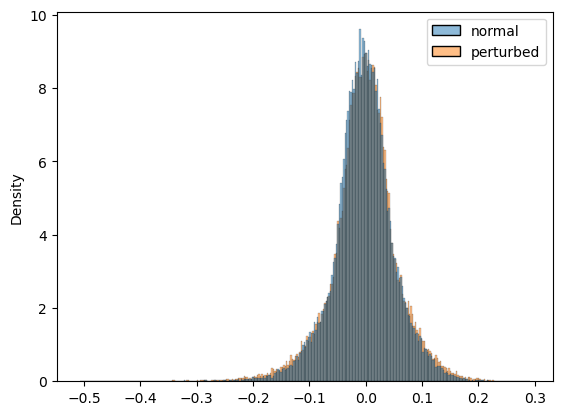

In [58]:
sns.histplot(df, stat="density", common_norm=False)

### Density Function

<Axes: ylabel='Density'>

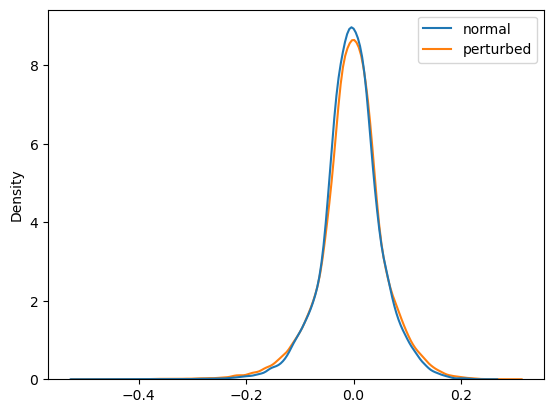

In [59]:
sns.kdeplot(df, common_norm=False)

### Cumulative Distribution Function

<Axes: ylabel='Density'>

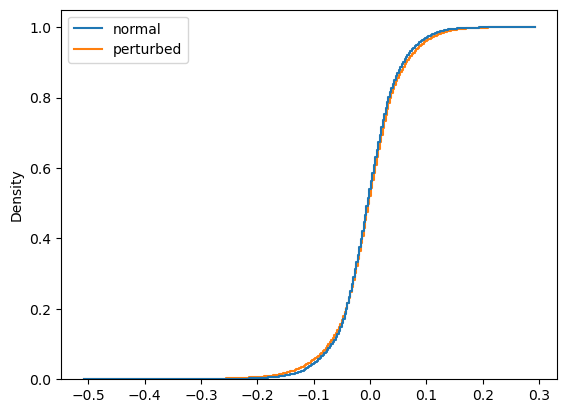

In [61]:
sns.histplot(df, stat="density", element="step", fill=False, cumulative=True, common_norm=False)

## Statistical Tests

### t-Test

In [63]:
from scipy.stats import ttest_ind

stat, p_value = ttest_ind(normal_net["fc_1.weight"].flatten(), perturbed_net["fc_1.weight"].flatten())
print(f"t-Test: statistic={stat:.4f}, p-value={p_value:.4f}")

t-Test: statistic=-2.6244, p-value=0.0087


### Mann-Whitney U Test

Null hypothesis: Both groups have the same distribution,